In [1]:
import numpy as np
import pandas as pd
import ssms
# import pytensor 
# import pytensor.tensor as pt


In [2]:
list(ssms.config.model_config.keys())

['ddm',
 'ddm_st',
 'ddm_truncnormt',
 'ddm_rayleight',
 'ddm_sdv',
 'ddm_par2',
 'ddm_par2_no_bias',
 'ddm_par2_conflict_gamma_no_bias',
 'ddm_par2_angle_no_bias',
 'ddm_par2_weibull_no_bias',
 'ddm_seq2',
 'ddm_seq2_no_bias',
 'ddm_seq2_conflict_gamma_no_bias',
 'ddm_seq2_angle_no_bias',
 'ddm_seq2_weibull_no_bias',
 'ddm_mic2_adj',
 'ddm_mic2_adj_no_bias',
 'ddm_mic2_adj_conflict_gamma_no_bias',
 'ddm_mic2_adj_angle_no_bias',
 'ddm_mic2_adj_weibull_no_bias',
 'ddm_mic2_ornstein',
 'ddm_mic2_ornstein_no_bias',
 'ddm_mic2_ornstein_no_bias_no_lowdim_noise',
 'ddm_mic2_ornstein_conflict_gamma_no_bias',
 'ddm_mic2_ornstein_conflict_gamma_no_bias_no_lowdim_noise',
 'ddm_mic2_ornstein_angle_no_bias',
 'ddm_mic2_ornstein_angle_no_bias_no_lowdim_noise',
 'ddm_mic2_ornstein_weibull_no_bias',
 'ddm_mic2_ornstein_weibull_no_bias_no_lowdim_noise',
 'ddm_mic2_leak',
 'ddm_mic2_leak_no_bias',
 'ddm_mic2_leak_no_bias_no_lowdim_noise',
 'ddm_mic2_leak_conflict_gamma_no_bias',
 'ddm_mic2_leak_conflic

In [36]:
from ssms.basic_simulators.simulator import simulator
mu0 = 5.0 # mu of ex-gaussian for choice 1
mu1 = 3 # mu of ex-gaussian for choice -1 
sigma0 = 0.5
sigma1 = 1
tau0 = 0.1
tau1 = 0.2
p_exgauss = 0.5

v0 = 2.0 
v1 = 3.0
a0 = 2.5 
a1 = 1
t = 0

sim_out_race = simulator(
    model="exgauss_race", theta={"mu0": mu0, "mu1": mu1, 
                            "sigma0": sigma0, "sigma1": sigma1, 
                            "tau0": tau0,
                             "tau1":tau1, "p": p_exgauss}, n_samples=10000, random_state = 100,
    )
sim_out = simulator(
    model="exgauss", theta={"mu0": mu0, "mu1": mu1, 
                            "sigma0": sigma0, "sigma1": sigma1, 
                            "tau0": tau0,
                             "tau1":tau1, "p": p_exgauss}, n_samples=10000, random_state = 100,
    )

sim_out_2 = simulator(
    model="shifted_wald", theta={"v0": v0, "v1": v1,
                                  "a0":a0, "a1":a1,
                                  "t": t, "p": 0.8}, n_samples=10000, random_state = 100,
    )
sim_out_2_race = simulator(
    model="shifted_wald_race", theta={"v0": v0, "v1": v1,
                                  "a0":a0, "a1":a1,
                                  "t": t, "p": 0.8}, n_samples=10000, random_state = 100
)


In [4]:
print(sim_out['rts'][:10])

[[1.4411364 ]
 [4.5396304 ]
 [1.9898669 ]
 [6.16694   ]
 [2.6007307 ]
 [1.695057  ]
 [0.32515216]
 [6.1096787 ]
 [1.4635196 ]
 [5.0182223 ]]


In [5]:
sim_out['choices']

array([[-1],
       [ 1],
       [-1],
       ...,
       [ 1],
       [-1],
       [-1]], shape=(10000, 1), dtype=int32)

In [6]:
sim_out_race['choices'][:1100]

array([[-1],
       [-1],
       [-1],
       ...,
       [-1],
       [-1],
       [-1]], shape=(1100, 1), dtype=int32)

In [7]:
print(sim_out_2['rts'])

[[1.7596234 ]
 [0.1787014 ]
 [0.67438966]
 ...
 [0.9025264 ]
 [0.73628825]
 [0.17353109]]


In [8]:
print(sim_out_2['choices'])

[[ 1]
 [-1]
 [ 1]
 ...
 [ 1]
 [ 1]
 [-1]]


In [9]:
print(sim_out_2_race['choices'])

[[-1]
 [-1]
 [-1]
 ...
 [-1]
 [-1]
 [-1]]


In [37]:
# Define exgauss analytical likelihoods
import numpy as np 
from scipy.stats import norm 


def exgauss_likelihood_bernoulli(x, choice, mu0, mu1, sigma0, sigma1, tau0, tau1, p):
    x = np.asarray(x, dtype=float)
    y = (np.asarray(choice, dtype=int) > 0) # 1 choice 
    mu = np.where(y, (float(mu0)), float(mu1))
    sigma = np.where(y, float(sigma0), float(sigma1))
    tau = np.where(y, float(tau0), float(tau1))

    tau_inv = 1.0 / tau 
    sig2 = sigma ** 2 
    z = (x - mu - sig2 * tau_inv) / sigma 
    cdf_gauss = norm.cdf(z)
    pdf_rt = tau_inv * np.exp(mu*tau_inv + (sig2 * tau_inv**2) / 2 - x*tau_inv) * cdf_gauss 
    
    # Bernoulli part 
    p = float(p)
    pdf_choice = np.where(y, p, 1 - p)

    return pdf_rt*pdf_choice 


x = np.linspace(0, 9, 1100)
choice = np.where(np.random.rand(len(x)) < p_exgauss, 1, -1)
pdf_vals = exgauss_likelihood_bernoulli(x, choice, mu0=mu0, mu1=mu1, sigma0=sigma0,
                                        sigma1=sigma1, tau0=tau0, tau1=tau1, p=p_exgauss)


In [38]:
# Define exgauss race likelihoods 

def exgauss_race_likelihoods(x, choice, mu0, mu1, sigma0, sigma1, tau0, tau1):
    x = np.asarray(x, dtype=float)
    y = (np.asarray(choice, dtype=int) > 0) # 1 choice 
    mu_winner = np.where(y, float(mu0), float(mu1))
    sigma_winner = np.where(y, float(sigma0), float(sigma1))
    tau_winner = np.where(y, float(tau0), float(tau1))

    mu_loser = np.where(y, float(mu1), float(mu0))
    sigma_loser = np.where(y, float(sigma1), float(sigma0))
    tau_loser = np.where(y, float(tau1), float(tau0))

    # Winner density 
    tau_inv_winner = 1.0 / tau_winner 
    sig2_winner = sigma_winner ** 2 
    z_winner = (x - mu_winner - sig2_winner * tau_inv_winner) / sigma_winner 
    cdf_gauss_winner = norm.cdf(z_winner)
    pdf_rt_winner = tau_inv_winner * np.exp(mu_winner*tau_inv_winner + (sig2_winner * tau_inv_winner**2) / 2 - x*tau_inv_winner) * cdf_gauss_winner 

    # Loser survival 
    z0_loser = (x -mu_loser) / sigma_loser 
    z1_loser = z0_loser - (sigma_loser / tau_loser)
    exp_factor = np.exp(- (x - mu_loser) / tau_loser + 0.5*(sigma_loser ** 2) / (tau_loser ** 2))
    F_loser = norm.cdf(z0_loser) - exp_factor * norm.cdf(z1_loser)
    surv_rt_loser = 1.0 - F_loser
    return pdf_rt_winner * surv_rt_loser

x_race = np.linspace(0, 9, 1000)
choice_race = (np.asarray(sim_out_race["choices"][:len(x_race)])).reshape(-1)
# choice_race = np.where(np.random.rand(len(x_race)) < p_race, 1, -1)
pdf_race_vals = exgauss_race_likelihoods(x_race, choice_race, mu0=mu0, mu1=mu1, sigma0=sigma0,
                                        sigma1=sigma1, tau0=tau0, tau1=tau1)


In [19]:
# define shifted wald analytical likelihoods

def shifted_wald_likelihood(x, choice, v0, v1, a0, a1, t, p):
    x = np.asarray(x, dtype=float)
    y = (np.asarray(choice, dtype=int) > 0) # 1 choice
    v = np.where(y, float(v0), float(v1))
    a = np.where(y, float(a0), float(a1))
    t = float(t)
    p = float(p)

    term_1 = (a / np.sqrt(2*np.pi*(x - t)**3))
    term_2 = np.exp((-(a-v*(x - t))**2) / (2*(x - t)))
    pdf_rt = term_1 * term_2

    # Bernoulli part
    pdf_choice = np.where(y, p, 1 - p)

    return pdf_rt*pdf_choice

x_sw = np.linspace(0.001, 9, 1100)
p_sw = 0.8
choice_sw = np.where(np.random.rand(len(x_sw)) < p_sw, 1, -1)
pdf_vals_sw = shifted_wald_likelihood(x_sw, choice_sw, v0=v0, v1=v1, a0=a0, a1=a1, t=0.0, p=0.8)


In [ ]:
# define shifted_wald race likelihoods 

def shifted_wald_race_likelihoods(x, choice, v0, v1, a0, a1, t):
    x = np.asarray(x, dtype=float)
    y = (np.asarray(choice, dtype=int) > 0) # 1 choice
    v_winner = np.where(y, float(v0), float(v1))
    a_winner = np.where(y, float(a0), float(a1))

    v_loser = np.where(y, float(v1), float(v0))
    a_loser = np.where(y, float(a1), float(a0))

    # Winner density 
    term_1_winner = (a_winner / np.sqrt(2*np.pi*(x - t)**3))
    term_2_winner = np.exp((-(a_winner-v_winner*(x - t))**2) / (2*(x - t)))
    pdf_rt_winner = term_1_winner * term_2_winner 

    # Loser survival 
    z_loser = (a_loser - v_loser * (x - t)) / np.sqrt(x - t)
    F_loser = norm.cdf(z_loser)
    surv_rt_loser = 1.0 - F_loser

Text(0.5, 1.0, 'Ex-Gaussian')

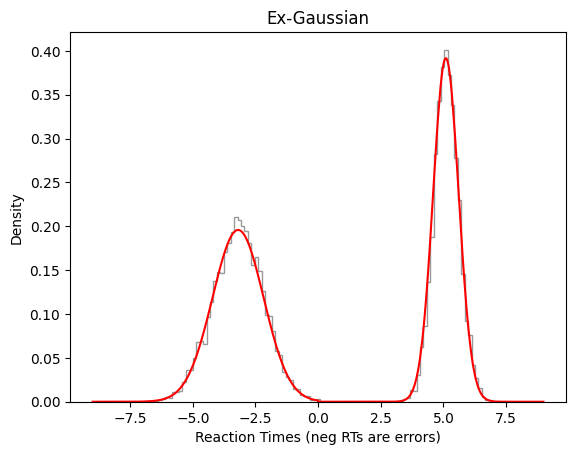

In [39]:
import matplotlib.pyplot as plt 
plt.hist(
    sim_out["rts"] * sim_out["choices"],
    bins=100,
    histtype="step",
    color="black",
    label="Weibull Deadline",
    density=True,
    alpha=0.4,
)
s = choice*x
idx = np.argsort(s) # sort the values so theyre not zig zaggy 
plt.plot(s[idx], pdf_vals[idx], color="red", label="Ex-Gaussian Likelihood")
plt.xlabel("Reaction Times (neg RTs are errors)")
plt.ylabel("Density")
plt.title("Ex-Gaussian")


Text(0.5, 1.0, 'Ex-Gaussian Race')

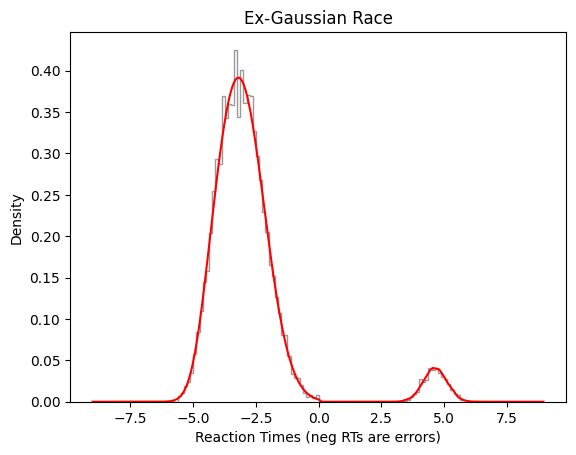

In [40]:
plt.hist(
    sim_out_race["rts"] * sim_out_race["choices"],
    bins=100,
    histtype="step",
    color="black",
    label="Weibull Deadline",
    density=True,
    alpha=0.4,
)
s_race = choice_race*x_race
idx_race = np.argsort(s_race) # sort the values so theyre not zig zaggy 
plt.plot(s_race[idx_race], pdf_race_vals[idx_race], color="red", label="Ex-Gaussian Likelihood")
plt.xlabel("Reaction Times (neg RTs are errors)")
plt.ylabel("Density")
plt.title("Ex-Gaussian Race")

Text(0, 0.5, 'Density')

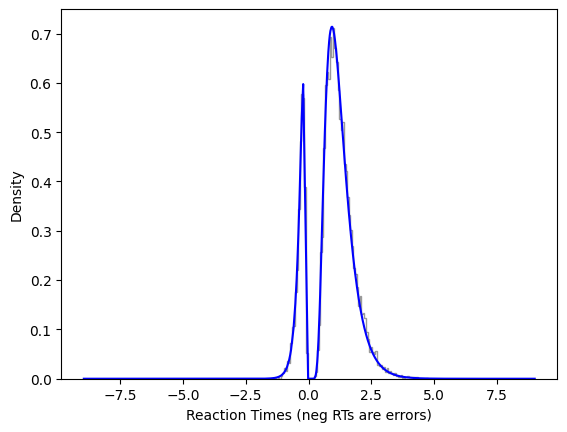

In [14]:
plt.hist(
    sim_out_2["rts"][sim_out_2["rts"] != -999] * sim_out_2["choices"][sim_out_2["rts"] != -999],
    bins=100,
    histtype="step",
    color="black",
    label="Weibull Deadline",
    density=True,
    alpha=0.4,
)
s_sw = choice_sw*x_sw
idx_sw = np.argsort(s_sw) # sort the values so theyre not zig zaggy
plt.plot(s_sw[idx_sw], pdf_vals_sw[idx_sw], color="blue", label="Shifted Wald Likelihood")
plt.xlabel("Reaction Times (neg RTs are errors)")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

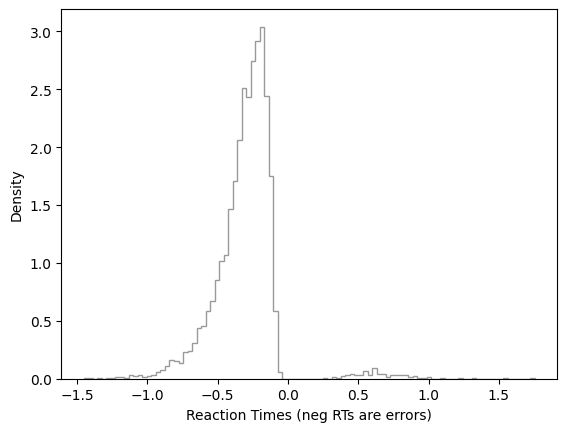

In [15]:
plt.hist(
    sim_out_2_race["rts"][sim_out_2_race["rts"] != -999] * sim_out_2_race["choices"][sim_out_2_race["rts"] != -999],
    bins=100,
    histtype="step",
    color="black",
    label="Weibull Deadline",
    density=True,
    alpha=0.4,
)
# s_sw = choice_sw*x_sw
# idx_sw = np.argsort(s_sw) # sort the values so theyre not zig zaggy
# plt.plot(s_sw[idx_sw], pdf_vals_sw[idx_sw], color="blue", label="Shifted Wald Likelihood")
plt.xlabel("Reaction Times (neg RTs are errors)")
plt.ylabel("Density")